# Logistic Growth

Populations cannot grow forever without restrictions, like exponential growth. A population would more realistically grow logistically: exponential at small numbers but slows down as the population nears a carrying capacity. This example builds several logistic growth models, outlining how more advanced models can be created.

## Differential Equation

Logistic growth model can be written as a differential equation,

\begin{equation*}
\frac{dN}{dt} = rN(t) \left( 1-\frac{N(t)}{k} \right)
\end{equation*}

where a population, $N$, increases by a growth rate, $r$, that is reduced as the population reaches its carrying capacity ($k$). There is a simple solution to this differential equation,

\begin{equation*}
\ N(t) = \frac{kN_0 e^{rt}}{k+N_0(e^{rt}-1)}
\end{equation*}

based on an initial population size, $N_0$. 

I'm going to make one change. The growth rate $r$ is the difference between  birth and death rates. ($r = b - d$) and both are density-dependent in the basic logistic model. Techincally, as the population approaches their carrying capacity, death rates decrease &mdash; that seems strange. Instead, the death rate is modelled as density-independent intrinsic factor.

\begin{equation*}
\frac{dN}{dt} = bN(t) \left( 1-\frac{N(t)}{k} \right) - dN(t)
\end{equation*}

Here's how to plot the solution in Python:

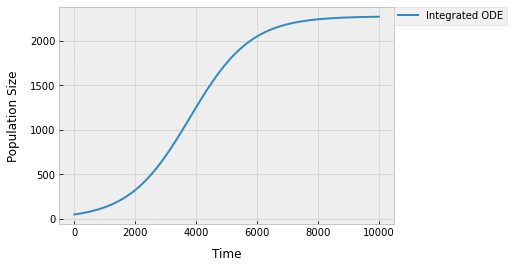

In [1]:
%matplotlib inline
# load required packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from scipy import integrate

# set parameters
birth_rate = 0.0011
death_rate = 0.0001
init_size = 50
xdim = 50
ydim = 50
k = xdim * ydim
time = 10000
de_times = np.linspace(0, time, 100) # inference times

# create exponential growth equation as a function of N
def dN_dt(N, t=0):
    return birth_rate * (1 - N[0]/k) * N[0] - death_rate * N[0]

# integrate growth equation
X, info = integrate.odeint(dN_dt, init_size, de_times, full_output=True)
# format and store results
de_pop, = X.T

# plot
fig, ax = plt.subplots()
ax.plot(de_times, de_pop, label='Integrated ODE')
ax.set_ylabel('Population Size', labelpad=10)
ax.set_xlabel('Time', labelpad=10)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0)
plt.show()

## Implicit IEBM

One way to model logistic growth is applying a very simple limit to a population size. For whatever phenomological reason, the population is not allowed to grow beyond this limit. Individual birth events are added to the event heap at the same birth rate, *b*. But when birth events are handled, there's a chance $(1-N/k)$ they do not occur.

In [2]:
import sys
sys.path.append('../../')
from iebm.populations.population2D import Population2D
from iebm.traits.static_trait import StaticTrait
from iebm.events.birth_asexual import BirthAsexualEvent, BirthAsexualDiffusionEvent
from iebm.events.death import DeathEvent
from iebm.simulation import Simulation

In [3]:
# we can recreate the exponential growth IEBM and add an implicit_capacity to the population 
# First lets create an empty 2D population. Each individual contains only a unique ID and x-y positions
log_pop = Population2D(name='log_pop',
                       init_size=init_size, 
                       implicit_capacity=k, # limit the population growth
                       xdim=xdim, ydim=ydim)

# create the same traits as the exponential growth example
trait_list = [(StaticTrait, {'name' : 'birth_rate', 
                             'value' : birth_rate}), 
              (StaticTrait, {'name' : 'death_rate', 
                             'value' : death_rate})]
log_pop.add_traits(trait_list)
# create the same events as the exponential growth example
event_list = [(BirthAsexualEvent, {'name' : 'birth',
                                   'is_primary' : True,
                                   'current_time' : 0}),
              (DeathEvent, {'name' : 'death', 
                            'is_primary' : True,
                            'current_time' : 0})]
log_pop.add_events(event_list)

In [4]:
%%time
# Add the exp_pop to a dictionary 
pop_dict = {str(log_pop) : log_pop}

# Create the simulation with the population dictionary
sim = Simulation(pop_dict)

# Run the simulation
sim.run(time)

# Store results
imp_pop = sim.population_history[str(log_pop)]
imp_times = sim.time_history

 99%|█████████▊| 9865.9961/10000 [00:05<00:00, 1367.21it/s] /home/jordan/miniconda3/envs/ebm/lib/python3.7/site-packages/tqdm/std.py:521: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
100%|██████████| 10000.0605/10000 [00:05<00:00, 1815.03it/s]

CPU times: user 42.9 s, sys: 25.3 ms, total: 43 s
Wall time: 5.52 s


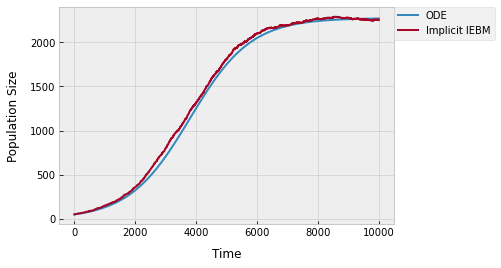

In [5]:
fig, ax = plt.subplots()
ax.plot(de_times, de_pop, label='ODE')
ax.plot(imp_times, imp_pop, label='Implicit IEBM')
ax.set_ylabel('Population Size', labelpad=10)
ax.set_xlabel('Time', labelpad=10)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0)
plt.show()

## Explicit IEBM
The other way to make a logistically growing population is to specifically add conspecific competition for space and not allow individuals to overlap. Individuals are given a *radius* to explicitly simulate space and a maximum distance offspring can spawn from their parent (*offspring_dist_max*). The *radius* is modelled as a simple *StaticTrait* that doesn't change. We could model the *offspring_dist_max* also as a *StaticTrait*, but this provides a simple example to use another *Trait*, a *LinkedTrait*. The *offspring_dist_max* depends on the *radius* of the individual and a factor. The *LinkedTrait* take the *radius* value and multiplies it by the factor to give the *offpsring_dist_max* value. These *LinkedTraits* are real helpful in future experiments. 

The *BirthEvent* is now a *BirthDiffusionEvent*, which is coded to spawn offpsring near parents based on the *radius* and *offspring_dist_max* *Trait* values. One option is that offspring are born near their parents and can overlap in space; in the other option, offspring cannot overlap. When individuals cannot overlap, their positions are stored in a *r-tree*, which is an efficient spatial data structure that quickly finds near by neighbours. When producing an offspring that cannot overlap, the parent neighbours are found with the *r-tree* and available space is determined by the vertices of a Voronoi diagram of the parents and neighbours positions. 

For a given environment size, there are different values of *radius* and *offspring_dist_max* that recreate the dynamics of the logistic growth ODE and implicit IEBM. In this example, from trial and error, a *radius* of about 0.4 and an *offspring_dist_max* of 20 have very similar dynamics as the above models.

In [6]:
from iebm.traits.linked_trait import LinkedTrait

In [7]:
def explicit_run(radius, odm_factor):
    # we can recreate the exponential growth IEBM and add an implicit_capacity to the population 
    # First lets create an empty 2D population. Each individual contains only a unique ID and x-y positions
    log_pop = Population2D(name='log_pop',
                           init_size=init_size, 
                           implicit_capacity=k, # limit the population growth
                           xdim=xdim, ydim=ydim)

    trait_list = [(StaticTrait, {'name' : 'radius', 
                                 'value' : radius}), 
                  (LinkedTrait, {'name' : 'offspring_dist_max', 
                                 'link_trait' : 'radius', 
                                 'link_func' : lambda x: x*odm_factor}),
                  (StaticTrait, {'name' : 'birth_rate', 
                                 'value' : birth_rate}), 
                  (StaticTrait, {'name' : 'death_rate', 
                                 'value' : death_rate})]
    log_pop.add_traits(trait_list)

    event_list = [(BirthAsexualDiffusionEvent, {'name' : 'birth',
                                                'is_primary' : True,
                                                'allow_overlap' : False,
                                                'current_time' : 0}),
                  (DeathEvent, {'name' : 'death', 
                                'is_primary' : True,
                                'current_time' : 0})]

    # add events
    log_pop.add_events(event_list)    
    
    # add a trigger
    log_pop.event_dict['birth'].triggers = log_pop.event_dict['birth'].insert_rtree
    log_pop.event_dict['death'].triggers = log_pop.event_dict['birth'].remove_rtree
    
    # Add the exp_pop to a dictionary 
    pop_dict = {str(log_pop) : log_pop}

    # Create the simulation with the population dictionary
    sim = Simulation(pop_dict)

    # Run the simulation
    sim.run(time)

    # Store results
    iebm_pop = sim.population_history[str(log_pop)]
    iebm_times = sim.time_history
    
    return iebm_times, iebm_pop
    

In [8]:
%%time
iebm_times, iebm_pop = explicit_run(0.4, 20)

100%|█████████▉| 9985.5125/10000 [01:10<00:00, 84.00it/s]  /home/jordan/miniconda3/envs/ebm/lib/python3.7/site-packages/tqdm/std.py:521: TqdmWarning: clamping frac to range [0, 1]
  colour=colour)
100%|██████████| 10000.2810/10000 [01:10<00:00, 141.48it/s]

CPU times: user 7min 47s, sys: 892 ms, total: 7min 47s
Wall time: 1min 10s


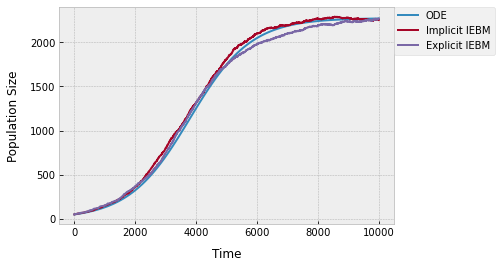

In [9]:
fig, ax = plt.subplots()
ax.plot(de_times, de_pop, label='ODE')
ax.plot(imp_times, imp_pop, label='Implicit IEBM')
ax.plot(iebm_times, iebm_pop, label='Explicit IEBM')
ax.set_ylabel('Population Size', labelpad=10)
ax.set_xlabel('Time', labelpad=10)
plt.legend(bbox_to_anchor=(1,1), loc='upper left', borderaxespad=0)
plt.show()